In [1]:
import numpy as np
from copy import copy

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Society:
    def __init__(self, alpha):
        self.alpha = alpha
        self.states = [[-1, 1]]
        self.cs = [[-1, 1]]
        self.time = 1
    
    def __str__(self):
        s = 'Alpha: {}\nTime: {}\nStates:\n'.format(self.alpha, self.time)
        for state in self.states:
            s += str(state) + '\n'
        for c in self.cs:
            s += str(c[1:]) + '\n'
        return s
        
    def random_update(self):
        self.states.append(copy(self.states[-1]))
        x = np.random.random()
        if x < self.alpha:
            # с вероятностью альфа - равновероятно
            n = np.random.randint(1, self.time + 1)
            summ = 0
            for i in range(1, len(self.states[-1])):
                if n <= summ:
                    break
                summ += self.states[-1][i]
                if n <= summ:
                    self.states[-1][i] -= 1
                    if i < len(self.states[-1]) - 1:
                        self.states[-1][i + 1] += 1
                    else:
                        self.states[-1].append(1)
        else:
            # иначе - "деньги к деньгам"
            n = np.random.randint(1, self.time * 2)
            summ = 0
            for i in range(1, len(self.states)):
                if n <= summ:
                    break
                summ += self.states[-1][i] * i
                if n <= summ:
                    self.states[-1][i] -= 1
                    if i < len(self.states[-1]) - 1:
                        self.states[-1][i + 1] += 1
                    else:
                        self.states[-1].append(1)
        self.states[-1][1] += 1
        self.cs.append(copy(self.states[-1]))
        summ = sum(self.states[-1][1:])
        for i in range(1, len(self.states[-1])):
            self.cs[-1][i] /= summ
        self.time += 1
        
    def estimated_update(self):
        self.states.append(copy(self.states[-1]))
        self.states[-1].append(0)
        beta_t = self.alpha / self.time
        gamma_t = (1 - self.alpha) / (self.time * 2 - 1)
        deltas = [1 - self.states[-1][1] * (beta_t + gamma_t)]
        for i in range(2, len(self.states[-1])):
            deltas.append(self.states[-1][i - 1] * (beta_t + gamma_t * (i - 1)) - 
                          self.states[-1][i] * (beta_t + gamma_t * i))
        for i in range(1, len(self.states[-1])):
            self.states[-1][i] += deltas[i - 1]
        self.cs.append(copy(self.states[-1]))
        summ = sum(self.states[-1][1:])
        for i in range(1, len(self.states[-1])):
            self.cs[-1][i] /= summ
        self.time += 1

In [4]:
def random_n_update(society, n, seed=1):
    np.random.seed(seed)
    for i in range(n):
        society.random_update()
        

def estimated_n_update(society, n):
    for i in range(n):
        society.estimated_update()

In [5]:
def c_norm(x):
    return max([abs(x) for x in x])


def c_distance(x, y):
    if len(x) < len(y):
        x += [0] * (len(y) - len(x))
    elif len(y) < len(x):
        y += [0] * (len(x) - len(y))
    return c_norm([x - y for x, y in zip(x, y)])

In [6]:
def get_k_from_c(c, left, right):
    log_c = np.log(c[left:right])
    log_n = np.log(np.arange(left, right, 1))
    plt.plot(log_c, log_n)
    return - (log_c * log_n).mean() / (log_n ** 2).mean()    

In [7]:
def create_c_limit(alpha, s_max=20001):
    c_limit = [-1, 1]
    k = (3 - alpha)/(1 - alpha)
    a = 2 * (1 + alpha) / (1 - alpha)
    for s in range(2, s_max):
        c_limit.append(c_limit[-1] * (1 - k / (s + a)))
    summ = sum(c_limit[1:])
    return [-1] + [x/summ for x in c_limit[1:]]

In [8]:
def create_c_false(alpha, s_max=20001):
    c_limit = [-1, 1]
    k = 3 + alpha/(1 - alpha)
    a = 2 * (1 + alpha) / (1 - alpha)
    for s in range(2, s_max):
        c_limit.append(c_limit[-1] * (1 - k / (s + a)))
    summ = sum(c_limit[1:])
    return [-1] + [x/summ for x in c_limit[1:]]

In [17]:
s = Society(0.5)
estimated_n_update(s, 10000)

In [18]:
c05 = create_c_limit(0.5, 30001)

In [19]:
print("Distance between 10 iterations and limit is {}".format(c_distance(s.cs[10], c05)))

Distance between 10 iterations and limit is 0.010101520983952166


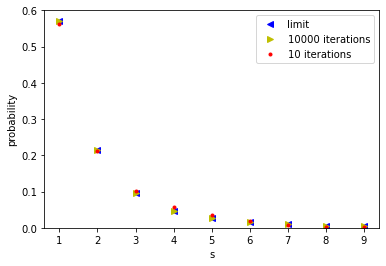

In [12]:
axes = plt.gca()
axes.set_ylim([0,0.6])
axes.set_xlabel('s')
axes.set_ylabel('probability')
plt.plot(range(1,10), c05[1:10], 'b<', label='limit')
plt.plot(range(1,10), s.cs[-1][1:10], 'y>', label='10000 iterations')
plt.plot(range(1,10), s.cs[10][1:10], 'r.', label='10 iterations')
plt.legend()

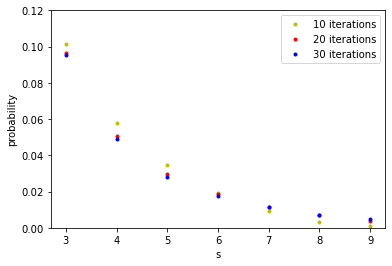

In [13]:
axes = plt.gca()
axes.set_ylim([0,0.12])
axes.set_xlabel('s')
axes.set_ylabel('probability')
plt.plot(range(3,10), s.cs[10][3:10], 'y.', label='10 iterations')
plt.plot(range(3,10), s.cs[20][3:10], 'r.', label='20 iterations')
plt.plot(range(3,10), s.cs[30][3:10], 'b.', label='30 iterations')
plt.legend()

Исследуем сходимость к пределу.

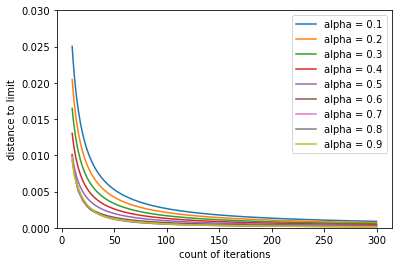

In [14]:
axes = plt.gca()
axes.set_ylim([0,0.03])
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    soc = Society(alpha)
    c_lim = create_c_limit(alpha, int(5000/alpha))
    estimated_n_update(soc, 1000)
    iters = range(10, 301, 1)
    dists = [c_distance(soc.cs[i], c_lim) for i in iters]
    plt.plot(iters, dists, '-', label='alpha = {}'.format(alpha))
plt.legend()

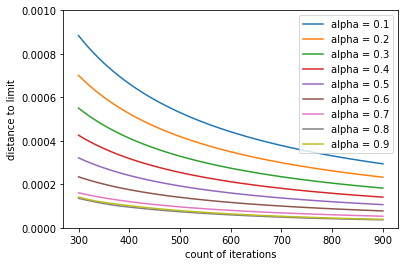

In [15]:
axes = plt.gca()
axes.set_ylim([0,0.001])
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    soc = Society(alpha)
    c_lim = create_c_limit(alpha, int(5000/alpha))
    estimated_n_update(soc, 1000)
    iters = range(300, 901, 10)
    dists = [c_distance(soc.cs[i], c_lim) for i in iters]
    plt.plot(iters, dists, '-', label='alpha = {}'.format(alpha))
plt.legend()

Сходимость среднего к приближению <<среднего поля>>.

In [16]:
n_samples = 10000
n_iter = 10
rands = {}
to_plot = {}
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    rands[alpha] = []
    for i in range(n_samples):
        sc = Society(alpha)
        random_n_update(sc, n_iter, i)
        rands[alpha].append(sc.cs[-1])
    length = max([len(x) for x in rands[alpha]])
    for i in range(n_samples):
        rands[alpha][i] += [0] * (length - len(rands[alpha][i]))
    arr = np.concatenate([np.array(rnd).reshape(1,-1) for rnd in rands[alpha]])
    sc = Society(alpha)
    estimated_n_update(sc, n_iter)
    to_plot[alpha] = []
    for i in range(1, n_samples + 1):
        dist_random = list(arr[0:i, :].mean(axis=0))
        to_plot[alpha].append(c_distance(dist_random, sc.cs[-1]))

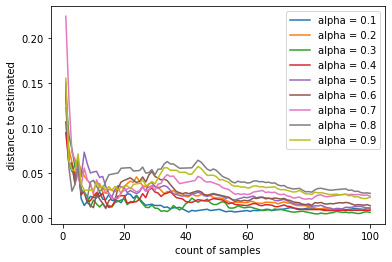

In [17]:
axes = plt.gca()
axes.set_xlabel('count of samples')
axes.set_ylabel('distance to estimated')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(1, 100 + 1), to_plot[alpha][0:100], '-', label='alpha = {}'.format(alpha))
plt.legend()

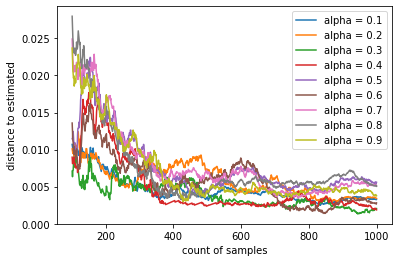

In [18]:
axes = plt.gca()
axes.set_xlabel('count of samples')
axes.set_ylabel('distance to estimated')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(101, 1000 + 1), to_plot[alpha][100:1000], '-', label='alpha = {}'.format(alpha))
plt.legend()

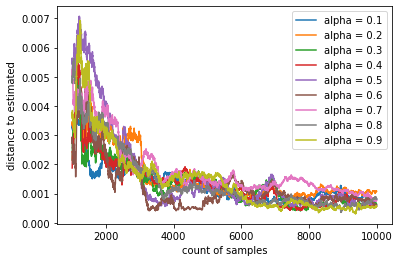

In [19]:
axes = plt.gca()
axes.set_xlabel('count of samples')
axes.set_ylabel('distance to estimated')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(1001, 10000 + 1), to_plot[alpha][1000:10000], '-', label='alpha = {}'.format(alpha))
plt.legend()

In [20]:
n_samples = 10000
n_iter = 100
rands = {}
to_plot = {}
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    rands[alpha] = []
    for i in range(n_samples):
        sc = Society(alpha)
        random_n_update(sc, n_iter, i)
        rands[alpha].append(sc.cs[-1])
    length = max([len(x) for x in rands[alpha]])
    for i in range(n_samples):
        rands[alpha][i] += [0] * (length - len(rands[alpha][i]))
    arr = np.concatenate([np.array(rnd).reshape(1,-1) for rnd in rands[alpha]])
    sc = Society(alpha)
    estimated_n_update(sc, n_iter)
    to_plot[alpha] = []
    for i in range(1, n_samples + 1):
        dist_random = list(arr[0:i, :].mean(axis=0))
        to_plot[alpha].append(c_distance(dist_random, sc.cs[-1]))

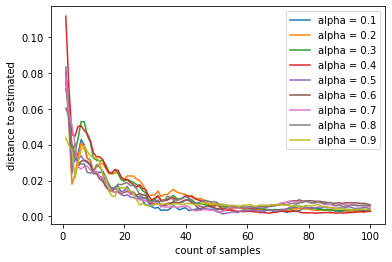

In [21]:
axes = plt.gca()
axes.set_xlabel('count of samples')
axes.set_ylabel('distance to estimated')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(1, 100 + 1), to_plot[alpha][0:100], '-', label='alpha = {}'.format(alpha))
plt.legend()

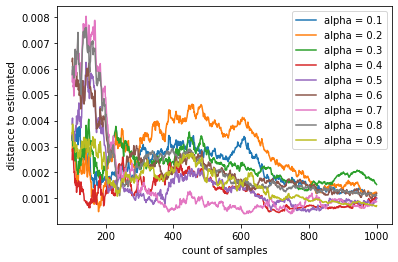

In [22]:
axes = plt.gca()
axes.set_xlabel('count of samples')
axes.set_ylabel('distance to estimated')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(101, 1000 + 1), to_plot[alpha][100:1000], '-', label='alpha = {}'.format(alpha))
plt.legend()

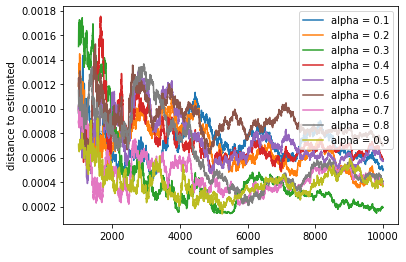

In [23]:
axes = plt.gca()
axes.set_xlabel('count of samples')
axes.set_ylabel('distance to estimated')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(1001, 10000 + 1), to_plot[alpha][1000:10000], '-', label='alpha = {}'.format(alpha))
plt.legend()

In [24]:
n_samples = 10000
n_iter = 1000
rands = {}
to_plot = {}
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    rands[alpha] = []
    for i in range(n_samples):
        sc = Society(alpha)
        random_n_update(sc, n_iter, i)
        rands[alpha].append(sc.cs[-1])
    length = max([len(x) for x in rands[alpha]])
    for i in range(n_samples):
        rands[alpha][i] += [0] * (length - len(rands[alpha][i]))
    arr = np.concatenate([np.array(rnd).reshape(1,-1) for rnd in rands[alpha]])
    sc = Society(alpha)
    estimated_n_update(sc, n_iter)
    to_plot[alpha] = []
    for i in range(1, n_samples + 1):
        dist_random = list(arr[0:i, :].mean(axis=0))
        to_plot[alpha].append(c_distance(dist_random, sc.cs[-1]))

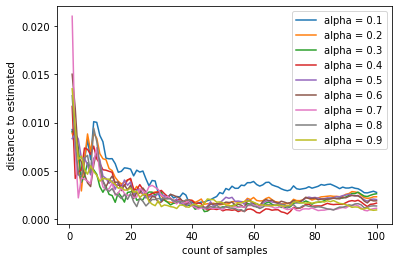

In [25]:
axes = plt.gca()
axes.set_xlabel('count of samples')
axes.set_ylabel('distance to estimated')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(1, 100 + 1), to_plot[alpha][0:100], '-', label='alpha = {}'.format(alpha))
plt.legend()

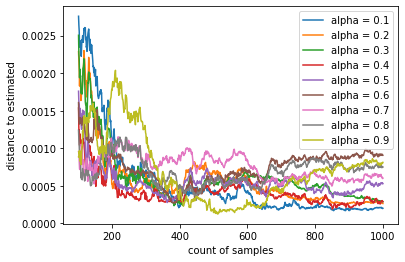

In [26]:
axes = plt.gca()
axes.set_xlabel('count of samples')
axes.set_ylabel('distance to estimated')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(101, 1000 + 1), to_plot[alpha][100:1000], '-', label='alpha = {}'.format(alpha))
plt.legend()

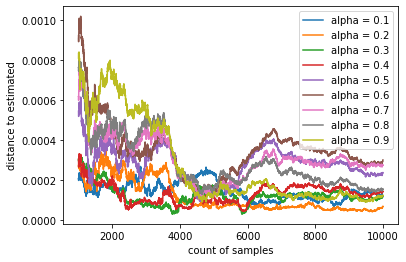

In [27]:
axes = plt.gca()
axes.set_xlabel('count of samples')
axes.set_ylabel('distance to estimated')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(1001, 10000 + 1), to_plot[alpha][1000:10000], '-', label='alpha = {}'.format(alpha))
plt.legend()

Сходимость среднего к предельному распределению.

In [28]:
n_samples = 10
n_iter = 10000
rands = {}
to_plot = {}
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    dist_lim = create_c_limit(alpha)
    rands[alpha] = []
    to_plot[alpha] = []
    for i in range(n_samples):
        sc = Society(alpha)
        random_n_update(sc, n_iter, i)
        rands[alpha].append(sc.cs)
    for i in range(n_iter):
        to_average = [rnd[i] for rnd in rands[alpha]]
        length = max([len(x) for x in to_average])
        for i in range(n_samples):
            to_average[i] += [0] * (length - len(to_average[i]))
        arr = np.concatenate([np.array(rnd).reshape(1,-1) for rnd in to_average])
        dist_random = list(arr.mean(axis=0))
        to_plot[alpha].append(c_distance(dist_random, dist_lim))

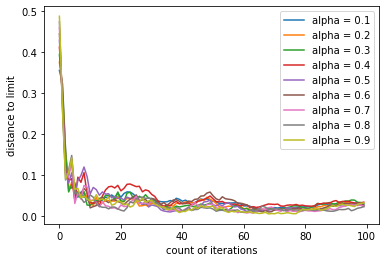

In [29]:
axes = plt.gca()
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(0, 100), to_plot[alpha][0:100], '-', label='alpha = {}'.format(alpha))
plt.legend()

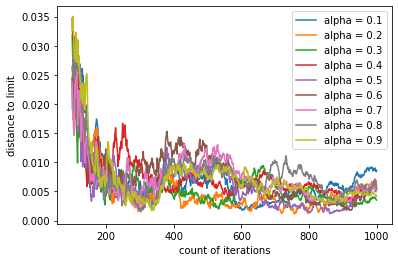

In [30]:
axes = plt.gca()
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(100, 1000), to_plot[alpha][100:1000], '-', label='alpha = {}'.format(alpha))
plt.legend()

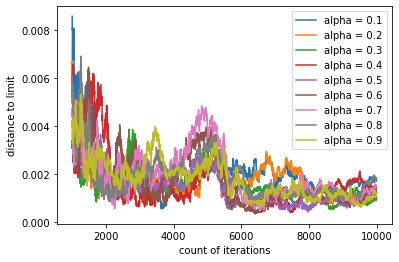

In [31]:
axes = plt.gca()
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(1000, 10000), to_plot[alpha][1000:10000], '-', label='alpha = {}'.format(alpha))
plt.legend()

In [8]:
n_iter = 10000
to_plot = {}
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    dist_lim = create_c_limit(alpha)
    sc = Society(alpha)
    random_n_update(sc, n_iter, 1)
    to_plot[alpha] = []
    for i in range(n_iter):
        to_plot[alpha].append(c_distance(sc.cs[i], dist_lim))

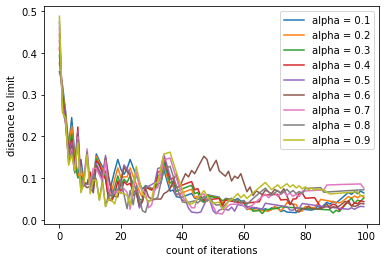

In [9]:
axes = plt.gca()
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(0, 100), to_plot[alpha][0:100], '-', label='alpha = {}'.format(alpha))
plt.legend()

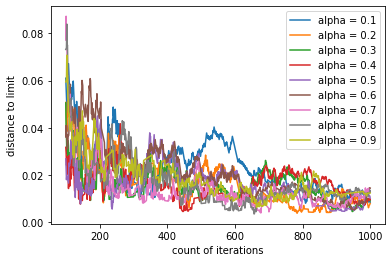

In [10]:
axes = plt.gca()
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(100, 1000), to_plot[alpha][100:1000], '-', label='alpha = {}'.format(alpha))
plt.legend()

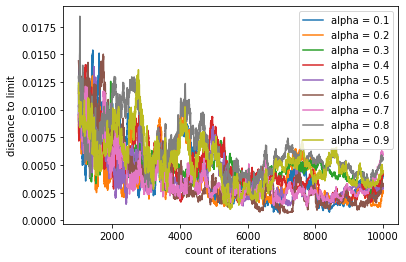

In [11]:
axes = plt.gca()
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(1000, 10000), to_plot[alpha][1000:10000], '-', label='alpha = {}'.format(alpha))
plt.legend()

In [12]:
n_iter = 20000
to_plot = {}
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    dist_lim = create_c_limit(alpha)
    sc = Society(alpha)
    random_n_update(sc, n_iter, 1)
    to_plot[alpha] = []
    for i in range(n_iter):
        to_plot[alpha].append(c_distance(sc.cs[i], dist_lim))

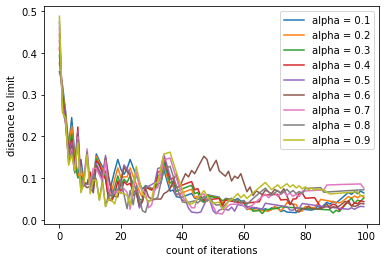

In [13]:
axes = plt.gca()
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(0, 100), to_plot[alpha][0:100], '-', label='alpha = {}'.format(alpha))
plt.legend()

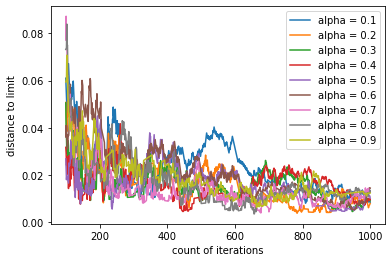

In [14]:
axes = plt.gca()
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(100, 1000), to_plot[alpha][100:1000], '-', label='alpha = {}'.format(alpha))
plt.legend()

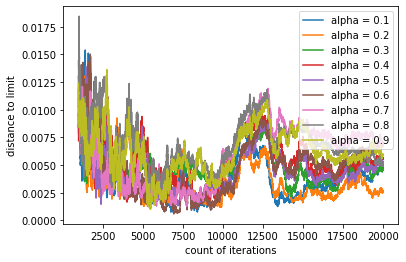

In [15]:
axes = plt.gca()
axes.set_xlabel('count of iterations')
axes.set_ylabel('distance to limit')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(range(1000, 20000), to_plot[alpha][1000:20000], '-', label='alpha = {}'.format(alpha))
plt.legend()

График в логарифмическом масштабе.

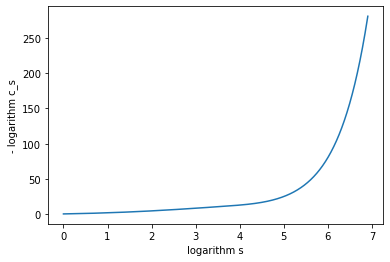

In [20]:
axes = plt.gca()
axes.set_xlabel('logarithm s')
axes.set_ylabel('- logarithm c_s')
plt.plot(np.log(np.arange(1, 1000, 1)), (-np.log(s.cs[-1][1:1000])))

[3.5545035085292254, 4.4961330818394805, 5.754045667699135, 7.20775594475634, 8.803826546368732, 10.514380825203004, 12.322636727394595, 14.217446057421112, 16.190871908345418]


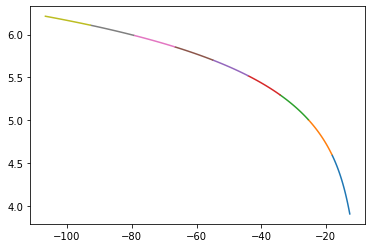

In [21]:
possible_k = []
for i in range(1, 10):
    k = get_k_from_c(s.cs[-1], 50 * i, 50 * i + 50)
    possible_k.append(k)
print(possible_k)